# <center> <span style="font-family: Virgil GS, sans-serif; color:#97f788">Naive Bayes</span> </center>
## <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">WOE & Boosting</span> </center>


 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [873]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import expit as sigmoid
from scipy.special import logit
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

In [874]:
features = [
    "external_risk_estimate",
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "num_total_cc_accounts",
    "average_months_in_file",
]

target = "is_bad"

In [875]:
X = dataset[features + [target]].copy()
y = X.pop("is_bad")
# X.replace([-9, -8, -7], np.nan, inplace=True)

ix_train, ix_test = train_test_split(X.index, test_size=0.3, random_state=62)

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">NB AdaBoost - baseline</span>

In [876]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score

nb_clf = GaussianNB(var_smoothing=1e-5)

nb_clf.fit(X.loc[ix_train], y.loc[ix_train])

predictions = nb_clf.predict_proba(X.loc[ix_test])[:,1]
gini = roc_auc_score(y.loc[ix_test], predictions) * 2 - 1 # type: ignore
print(f"Gini score: {gini:.2%}")

Gini score: 77.56%


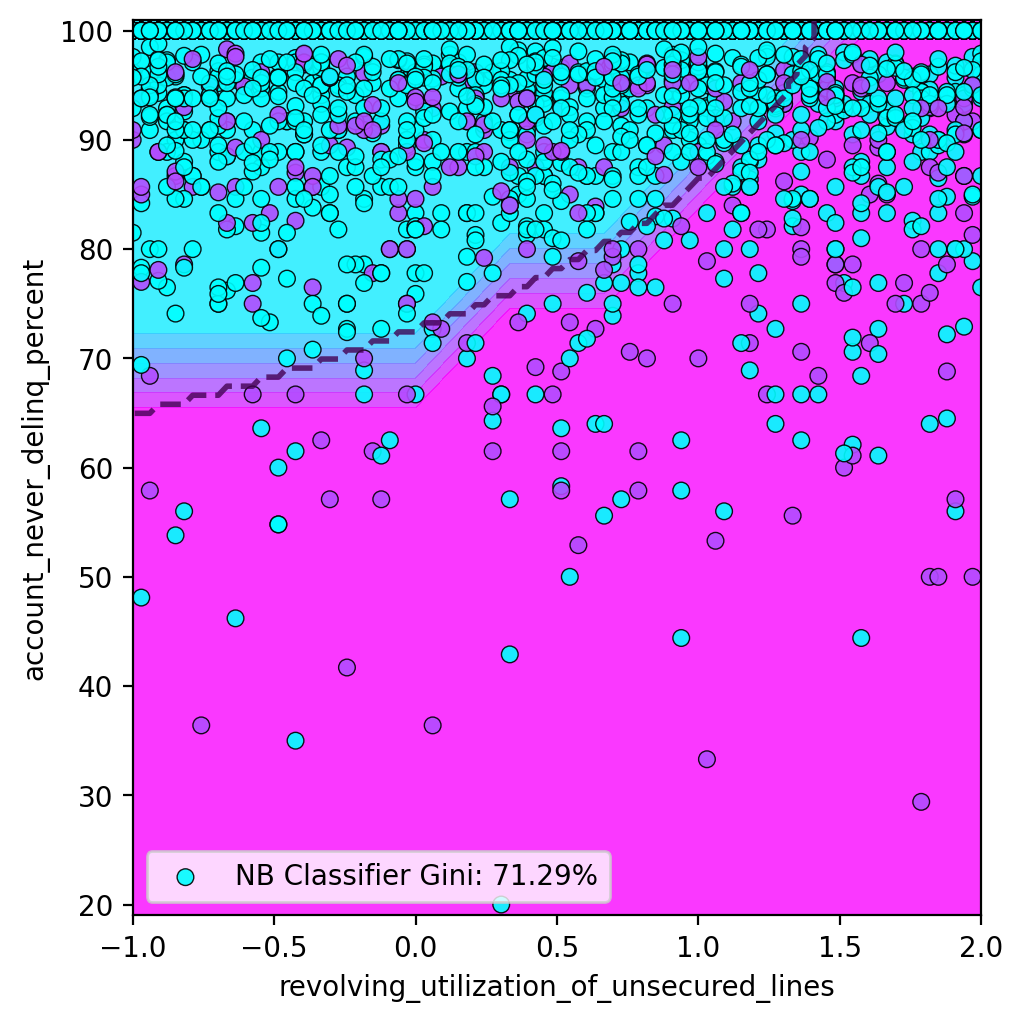

In [1048]:
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
%config InlineBackend.figure_format = 'retina'

colors = plt.get_cmap("cool")(0,5), plt.get_cmap("cool")(0.7)
common_scatter_plot_params = dict(
    cmap=ListedColormap([colors[0], colors[1]]),
    edgecolor="black",
    linewidth=0.5,
)

paired_features = [
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
]
nb_clf.fit(X.loc[ix_train][paired_features], y.loc[ix_train])
predictions = nb_clf.predict_proba(X.loc[ix_test][paired_features])[:,1]
gini = roc_auc_score(y.loc[ix_test], predictions) * 2 - 1 # type: ignore
accuracy = nb_clf.score(X.loc[ix_test][paired_features], y.loc[ix_test])

fig, ax = plt.subplots(
    figsize=(5, 5),
    constrained_layout=True,
)

DecisionBoundaryDisplay.from_estimator(
    nb_clf,
    X.loc[ix_test][paired_features],
    response_method="predict",
    plot_method="contourf",
    cmap="cool",
    grid_resolution=10,
    alpha=0.8,
    vmin=0,
    vmax=1,
    ax=ax,
)

DecisionBoundaryDisplay.from_estimator(
    nb_clf,
    X.loc[ix_test][paired_features],
    response_method="predict",
    plot_method="contour",
    alpha=0.8,
    levels=[0.5],  # 0.5 probability contour line
    linestyles="--",
    linewidths=2,
    ax=ax,
)

eps = 1.0
x0_min, x0_max = (
    X.loc[ix_test][paired_features[0]].min() - eps,
    X.loc[ix_test][paired_features[0]].max() + eps,
)
x1_min, x1_max = (
    X.loc[ix_test][paired_features[1]].min() - eps,
    X.loc[ix_test][paired_features[1]].max() + eps,
)

feature_1, feature_2 = np.meshgrid(
    np.linspace(x0_min, x0_max, 100),
    np.linspace(x1_min, x1_max, 100),
)

X_grid = X.loc[ix_test][paired_features].iloc[[], :].copy()
X_grid.iloc[:, 0] = feature_1.ravel()
X_grid.iloc[:, 1] = feature_2.ravel()

ax.scatter(
    X_grid.loc[ix_test].iloc[:, 0],
    X.loc[ix_test][paired_features[1]],
    c=y.loc[ix_test],
    **common_scatter_plot_params,
    label=f"NB Classifier Gini: {gini:.2%}",
    alpha=0.9
)
plt.legend()
plt.show()

In [1164]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_clf = AdaBoostClassifier(
    estimator=GaussianNB(var_smoothing=1e-5),
    n_estimators=100,
    learning_rate=0.1,
    random_state=0
)

adaboost_clf.fit(X.loc[ix_train], y.loc[ix_train])
predictions = adaboost_clf.predict_proba(X.loc[ix_test])[:,1]
gini = roc_auc_score(y.loc[ix_test], predictions) * 2 - 1 # type: ignore
print(f"Gini score: {gini:.2%}")

Gini score: 85.48%


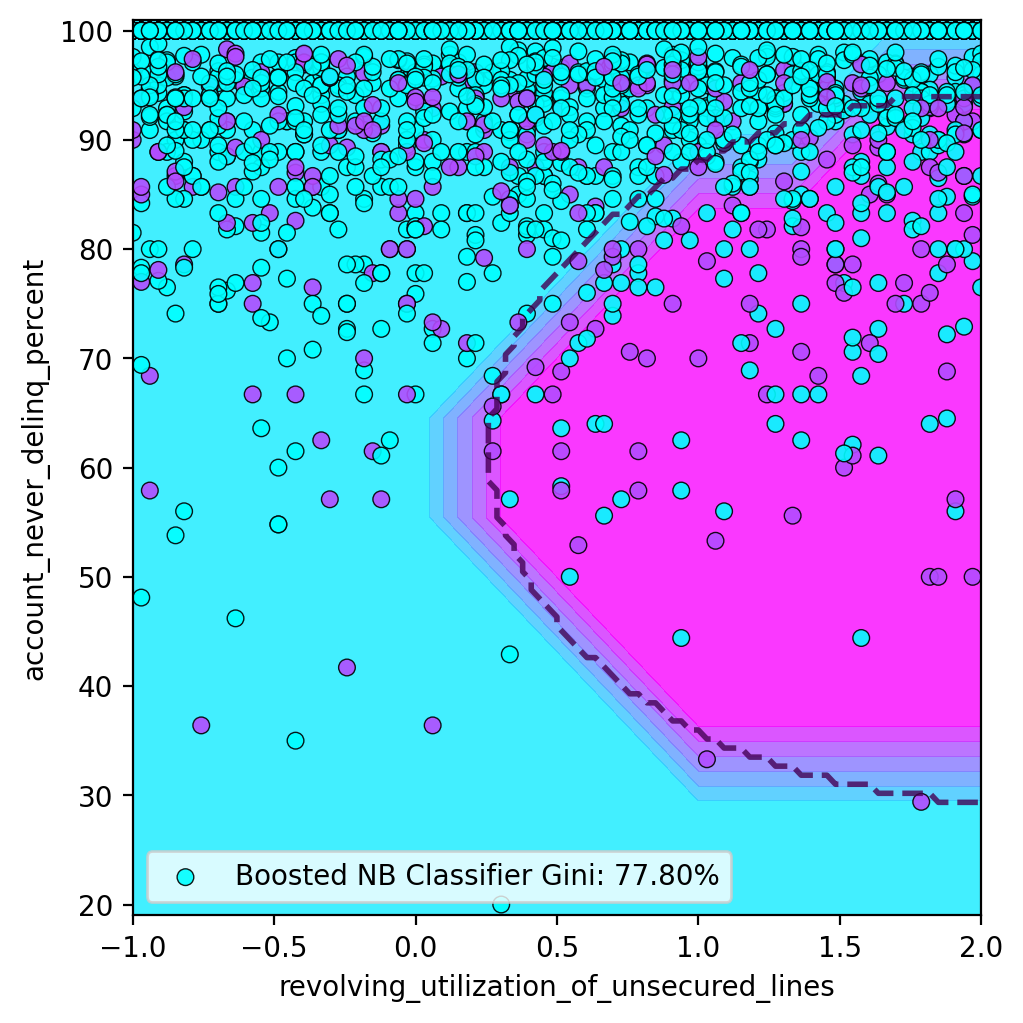

In [1165]:
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
%config InlineBackend.figure_format = 'retina'

colors = plt.get_cmap("cool")(0,5), plt.get_cmap("cool")(0.7)
common_scatter_plot_params = dict(
    cmap=ListedColormap([colors[0], colors[1]]),
    edgecolor="black",
    linewidth=0.5,
)

paired_features = [
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
]
adaboost_clf.fit(X.loc[ix_train][paired_features], y.loc[ix_train])
predictions = adaboost_clf.predict_proba(X.loc[ix_test][paired_features])[:,1]
gini = roc_auc_score(y.loc[ix_test], predictions) * 2 - 1 # type: ignore
accuracy = adaboost_clf.score(X.loc[ix_test][paired_features], y.loc[ix_test])

fig, ax = plt.subplots(
    figsize=(5, 5),
    constrained_layout=True,
)

DecisionBoundaryDisplay.from_estimator(
    adaboost_clf,
    X.loc[ix_test][paired_features],
    response_method="predict",
    plot_method="contourf",
    cmap="cool",
    grid_resolution=10,
    alpha=0.8,
    vmin=0,
    vmax=1,
    ax=ax,
)

DecisionBoundaryDisplay.from_estimator(
    adaboost_clf,
    X.loc[ix_test][paired_features],
    response_method="predict",
    plot_method="contour",
    alpha=0.8,
    levels=[0.5],  # 0.5 probability contour line
    linestyles="--",
    linewidths=2,
    ax=ax,
)

eps = 1.0
x0_min, x0_max = (
    X.loc[ix_test][paired_features[0]].min() - eps,
    X.loc[ix_test][paired_features[0]].max() + eps,
)
x1_min, x1_max = (
    X.loc[ix_test][paired_features[1]].min() - eps,
    X.loc[ix_test][paired_features[1]].max() + eps,
)

feature_1, feature_2 = np.meshgrid(
    np.linspace(x0_min, x0_max, 100),
    np.linspace(x1_min, x1_max, 100),
)

X_grid = X.loc[ix_test][paired_features].iloc[[], :].copy()
X_grid.iloc[:, 0] = feature_1.ravel()
X_grid.iloc[:, 1] = feature_2.ravel()

ax.scatter(
    X_grid.loc[ix_test].iloc[:, 0],
    X.loc[ix_test][paired_features[1]],
    c=y.loc[ix_test],
    **common_scatter_plot_params,
    label=f"Boosted NB Classifier Gini: {gini:.2%}",
    alpha=0.9
)
plt.legend()
plt.show()

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Gaussian NB WOE</span>

In [1109]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class Classifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.base_log_odds = 0  # Initialize base log odds
        self.is_fitted_ = False  # Add an attribute to track if the model is fitted
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def fit(self, X, y):
        self.base_log_odds = np.log(np.mean(y) / (1 - np.mean(y)))
        self.is_fitted_ = True  # Set is_fitted_ to True after fitting
        return self
    
    def predict_proba(self, X):
        if not self.is_fitted_:
            raise NotFittedError("This Classifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.")
        
        predicted_log_odds = X.sum(axis=1) + self.base_log_odds
        prob_positive_class = self.sigmoid(predicted_log_odds)
        return np.column_stack((1 - prob_positive_class, prob_positive_class))
    
    def predict(self, X):
        predicted_proba = self.predict_proba(X)
        return np.argmax(predicted_proba, axis=1)

In [1112]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import (
    KBinsDiscretizer,
    TargetEncoder,  # type: ignore
    FunctionTransformer
)
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

base_log_odds = np.log(np.mean(y.loc[ix_train]) / (1 - np.mean(y.loc[ix_train])))

# This means we take average DR in bin and convert to log-odds like intercept
# After this we subtract the intercept to create WOE scores
def convert_to_woe(X: np.ndarray):
    X = np.clip(X, 1e-5, 1 - 1e-5)
    # we get log odds first
    X = np.log(X / (1 - X))
    # then we subtract the base log odds
    X = X - base_log_odds
    return X

# create an Naive Bayes pipeline
nb_pipe_woe_clf = Pipeline(
    [
        (
            "discretizer",
            KBinsDiscretizer(
                n_bins=30, 
                encode="ordinal", 
                strategy="kmeans", 
                random_state=0
            ).set_output(transform="pandas"),
        ),
        (
            "encoder", TargetEncoder(smooth=1.0, random_state=0)),
        (
            "woe", FunctionTransformer(convert_to_woe, validate=False)),
        (
            "sigmoid_classifier",
            Classifier(),
        ),
    ]
)

nb_pipe_woe_clf.fit(X.loc[ix_train], y.loc[ix_train])

predictions = nb_pipe_woe_clf.predict_proba(X.loc[ix_train])[:, 1]
gini = roc_auc_score(y.loc[ix_train], predictions) * 2 - 1  # type: ignore
print(f"Gini train score: {gini:.2%}")

predictions = nb_pipe_woe_clf.predict_proba(X.loc[ix_test])[:, 1]
gini = roc_auc_score(y.loc[ix_test], predictions) * 2 - 1  # type: ignore
print(f"Gini test score: {gini:.2%}")

# Gini train score: 88.75%
# Gini test score: 88.57%

Gini train score: 88.75%
Gini test score: 88.57%


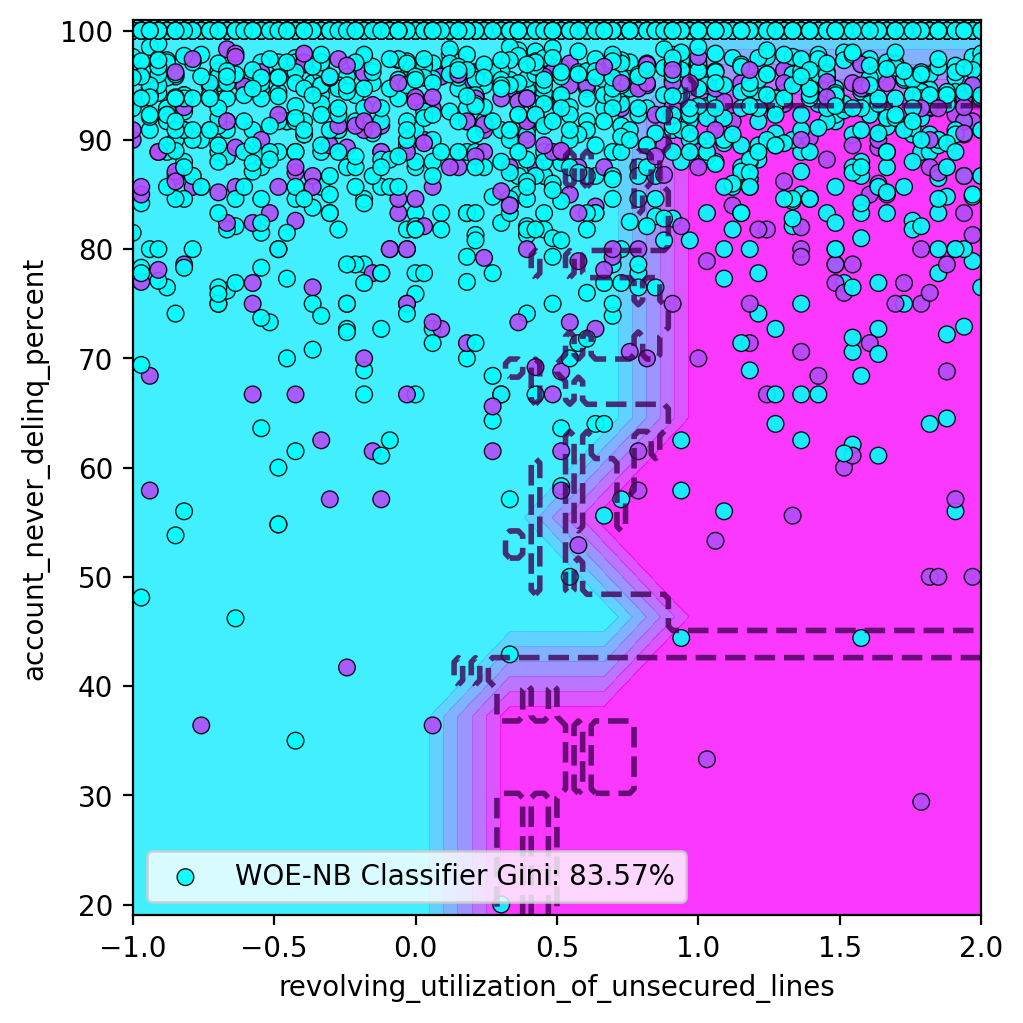

In [1113]:
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
%config InlineBackend.figure_format = 'retina'

colors = plt.get_cmap("cool")(0,5), plt.get_cmap("cool")(0.7)
common_scatter_plot_params = dict(
    cmap=ListedColormap([colors[0], colors[1]]),
    edgecolor="black",
    linewidth=0.5,
)

paired_features = [
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
]
nb_pipe_woe_clf.fit(X.loc[ix_train][paired_features], y.loc[ix_train])

predictions = nb_pipe_woe_clf.predict_proba(X.loc[ix_test][paired_features])[:,1]
gini = roc_auc_score(y.loc[ix_test], predictions) * 2 - 1 # type: ignore

fig, ax = plt.subplots(
    figsize=(5, 5),
    constrained_layout=True,
)

DecisionBoundaryDisplay.from_estimator(
    nb_pipe_woe_clf,
    X.loc[ix_test][paired_features],
    response_method="predict",
    plot_method="contourf",
    cmap="cool",
    grid_resolution=10,
    alpha=0.8,
    vmin=0,
    vmax=1,
    ax=ax,
)

DecisionBoundaryDisplay.from_estimator(
    nb_pipe_woe_clf,
    X.loc[ix_test][paired_features],
    response_method="predict",
    plot_method="contour",
    alpha=0.8,
    levels=[0.5],  # 0.5 probability contour line
    linestyles="--",
    linewidths=2,
    ax=ax,
)

eps = 1.0
x0_min, x0_max = (
    X.loc[ix_test][paired_features[0]].min() - eps,
    X.loc[ix_test][paired_features[0]].max() + eps,
)
x1_min, x1_max = (
    X.loc[ix_test][paired_features[1]].min() - eps,
    X.loc[ix_test][paired_features[1]].max() + eps,
)

feature_1, feature_2 = np.meshgrid(
    np.linspace(x0_min, x0_max, 100),
    np.linspace(x1_min, x1_max, 100),
)

X_grid = X.loc[ix_test][paired_features].iloc[[], :].copy()
X_grid.iloc[:, 0] = feature_1.ravel()
X_grid.iloc[:, 1] = feature_2.ravel()

ax.scatter(
    X_grid.loc[ix_test].iloc[:, 0],
    X.loc[ix_test][paired_features[1]],
    c=y.loc[ix_test],
    **common_scatter_plot_params,
    label=f"WOE-NB Classifier Gini: {gini:.2%}",
    alpha=0.9
)
plt.legend()
plt.show()

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Gaussian NB WOE AdaBoost</span>

In [1157]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import (
    KBinsDiscretizer,
    TargetEncoder,  # type: ignore
    FunctionTransformer
)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.filterwarnings("ignore")

base_log_odds = np.log(np.mean(y.loc[ix_train]) / (1 - np.mean(y.loc[ix_train])))

# This means we take average DR in bin and convert to log-odds like intercept
# After this we subtract the intercept to create WOE scores
def convert_to_woe(X: np.ndarray):
    X = np.clip(X, 1e-5, 1 - 1e-5)
    # we get log odds first
    X = np.log(X / (1 - X))
    # then we subtract the base log odds
    X = X - base_log_odds
    return X

# create an Naive Bayes pipeline
nb_pipe_woe_adaboost = Pipeline(
    [
        (
            "discretizer",
            KBinsDiscretizer(
                n_bins=30, 
                encode="ordinal", 
                strategy="kmeans", 
                random_state=0
            ).set_output(transform="pandas"),
        ),
        (
            "encoder", TargetEncoder(smooth=1.0, random_state=0)),
        (
            "woe", FunctionTransformer(convert_to_woe, validate=False)),
        (
            "adaboost",
            AdaBoostClassifier(
                estimator=GaussianNB(var_smoothing=1e-1),
                n_estimators=200,
                learning_rate=0.001,
                random_state=0,
            ),
        ),
    ]
)

nb_pipe_woe_adaboost.fit(X.loc[ix_train], y.loc[ix_train])

predictions = nb_pipe_woe_adaboost.predict_proba(X.loc[ix_train])[:, 1]
gini = roc_auc_score(y.loc[ix_train], predictions) * 2 - 1  # type: ignore
print(f"Gini train score: {gini:.2%}")

predictions = nb_pipe_woe_adaboost.predict_proba(X.loc[ix_test])[:, 1]
gini = roc_auc_score(y.loc[ix_test], predictions) * 2 - 1  # type: ignore
print(f"Gini test score: {gini:.2%}")

Gini train score: 88.54%
Gini test score: 88.74%


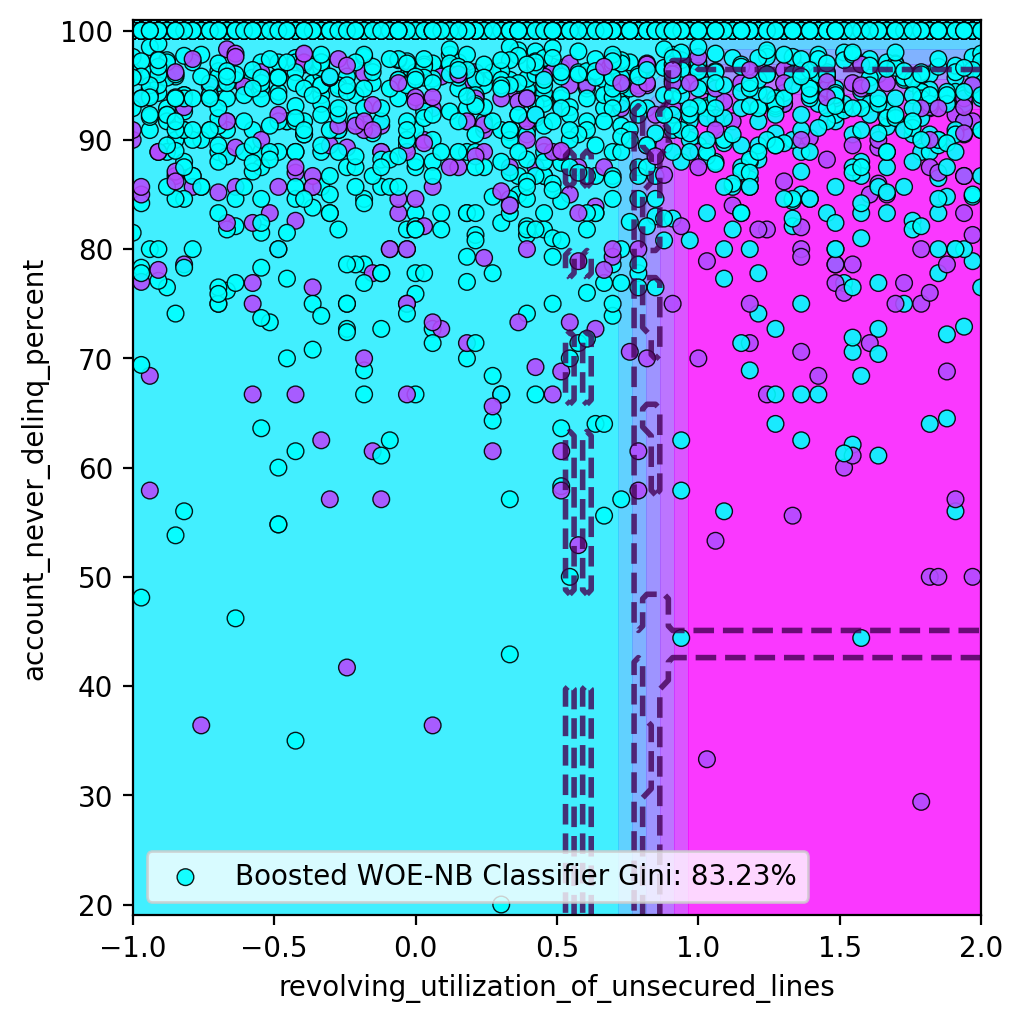

In [1159]:
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
%config InlineBackend.figure_format = 'retina'

colors = plt.get_cmap("cool")(0,5), plt.get_cmap("cool")(0.7)
common_scatter_plot_params = dict(
    cmap=ListedColormap([colors[0], colors[1]]),
    edgecolor="black",
    linewidth=0.5,
)

paired_features = [
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
]
nb_pipe_woe_adaboost.fit(X.loc[ix_train][paired_features], y.loc[ix_train])
predictions = nb_pipe_woe_adaboost.predict_proba(X.loc[ix_test][paired_features])[:,1]
gini = roc_auc_score(y.loc[ix_test], predictions) * 2 - 1 # type: ignore

fig, ax = plt.subplots(
    figsize=(5, 5),
    constrained_layout=True,
)

DecisionBoundaryDisplay.from_estimator(
    nb_pipe_woe_adaboost,
    X.loc[ix_test][paired_features],
    response_method="predict",
    plot_method="contourf",
    cmap="cool",
    grid_resolution=10,
    alpha=0.8,
    vmin=0,
    vmax=1,
    ax=ax,
)

DecisionBoundaryDisplay.from_estimator(
    nb_pipe_woe_adaboost,
    X.loc[ix_test][paired_features],
    response_method="predict",
    plot_method="contour",
    alpha=0.8,
    levels=[0.5],  # 0.5 probability contour line
    linestyles="--",
    linewidths=2,
    ax=ax,
)

eps = 1.0
x0_min, x0_max = (
    X.loc[ix_test][paired_features[0]].min() - eps,
    X.loc[ix_test][paired_features[0]].max() + eps,
)
x1_min, x1_max = (
    X.loc[ix_test][paired_features[1]].min() - eps,
    X.loc[ix_test][paired_features[1]].max() + eps,
)

feature_1, feature_2 = np.meshgrid(
    np.linspace(x0_min, x0_max, 100),
    np.linspace(x1_min, x1_max, 100),
)

X_grid = X.loc[ix_test][paired_features].iloc[[], :].copy()
X_grid.iloc[:, 0] = feature_1.ravel()
X_grid.iloc[:, 1] = feature_2.ravel()

ax.scatter(
    X_grid.loc[ix_test].iloc[:, 0],
    X.loc[ix_test][paired_features[1]],
    c=y.loc[ix_test],
    **common_scatter_plot_params,
    label=f"Boosted WOE-NB Classifier Gini: {gini:.2%}",
    alpha=0.9
)
plt.legend()
plt.show()

### <span style="font-family: Virgil GS, sans-serif; color:navyblue">Calibration</span>

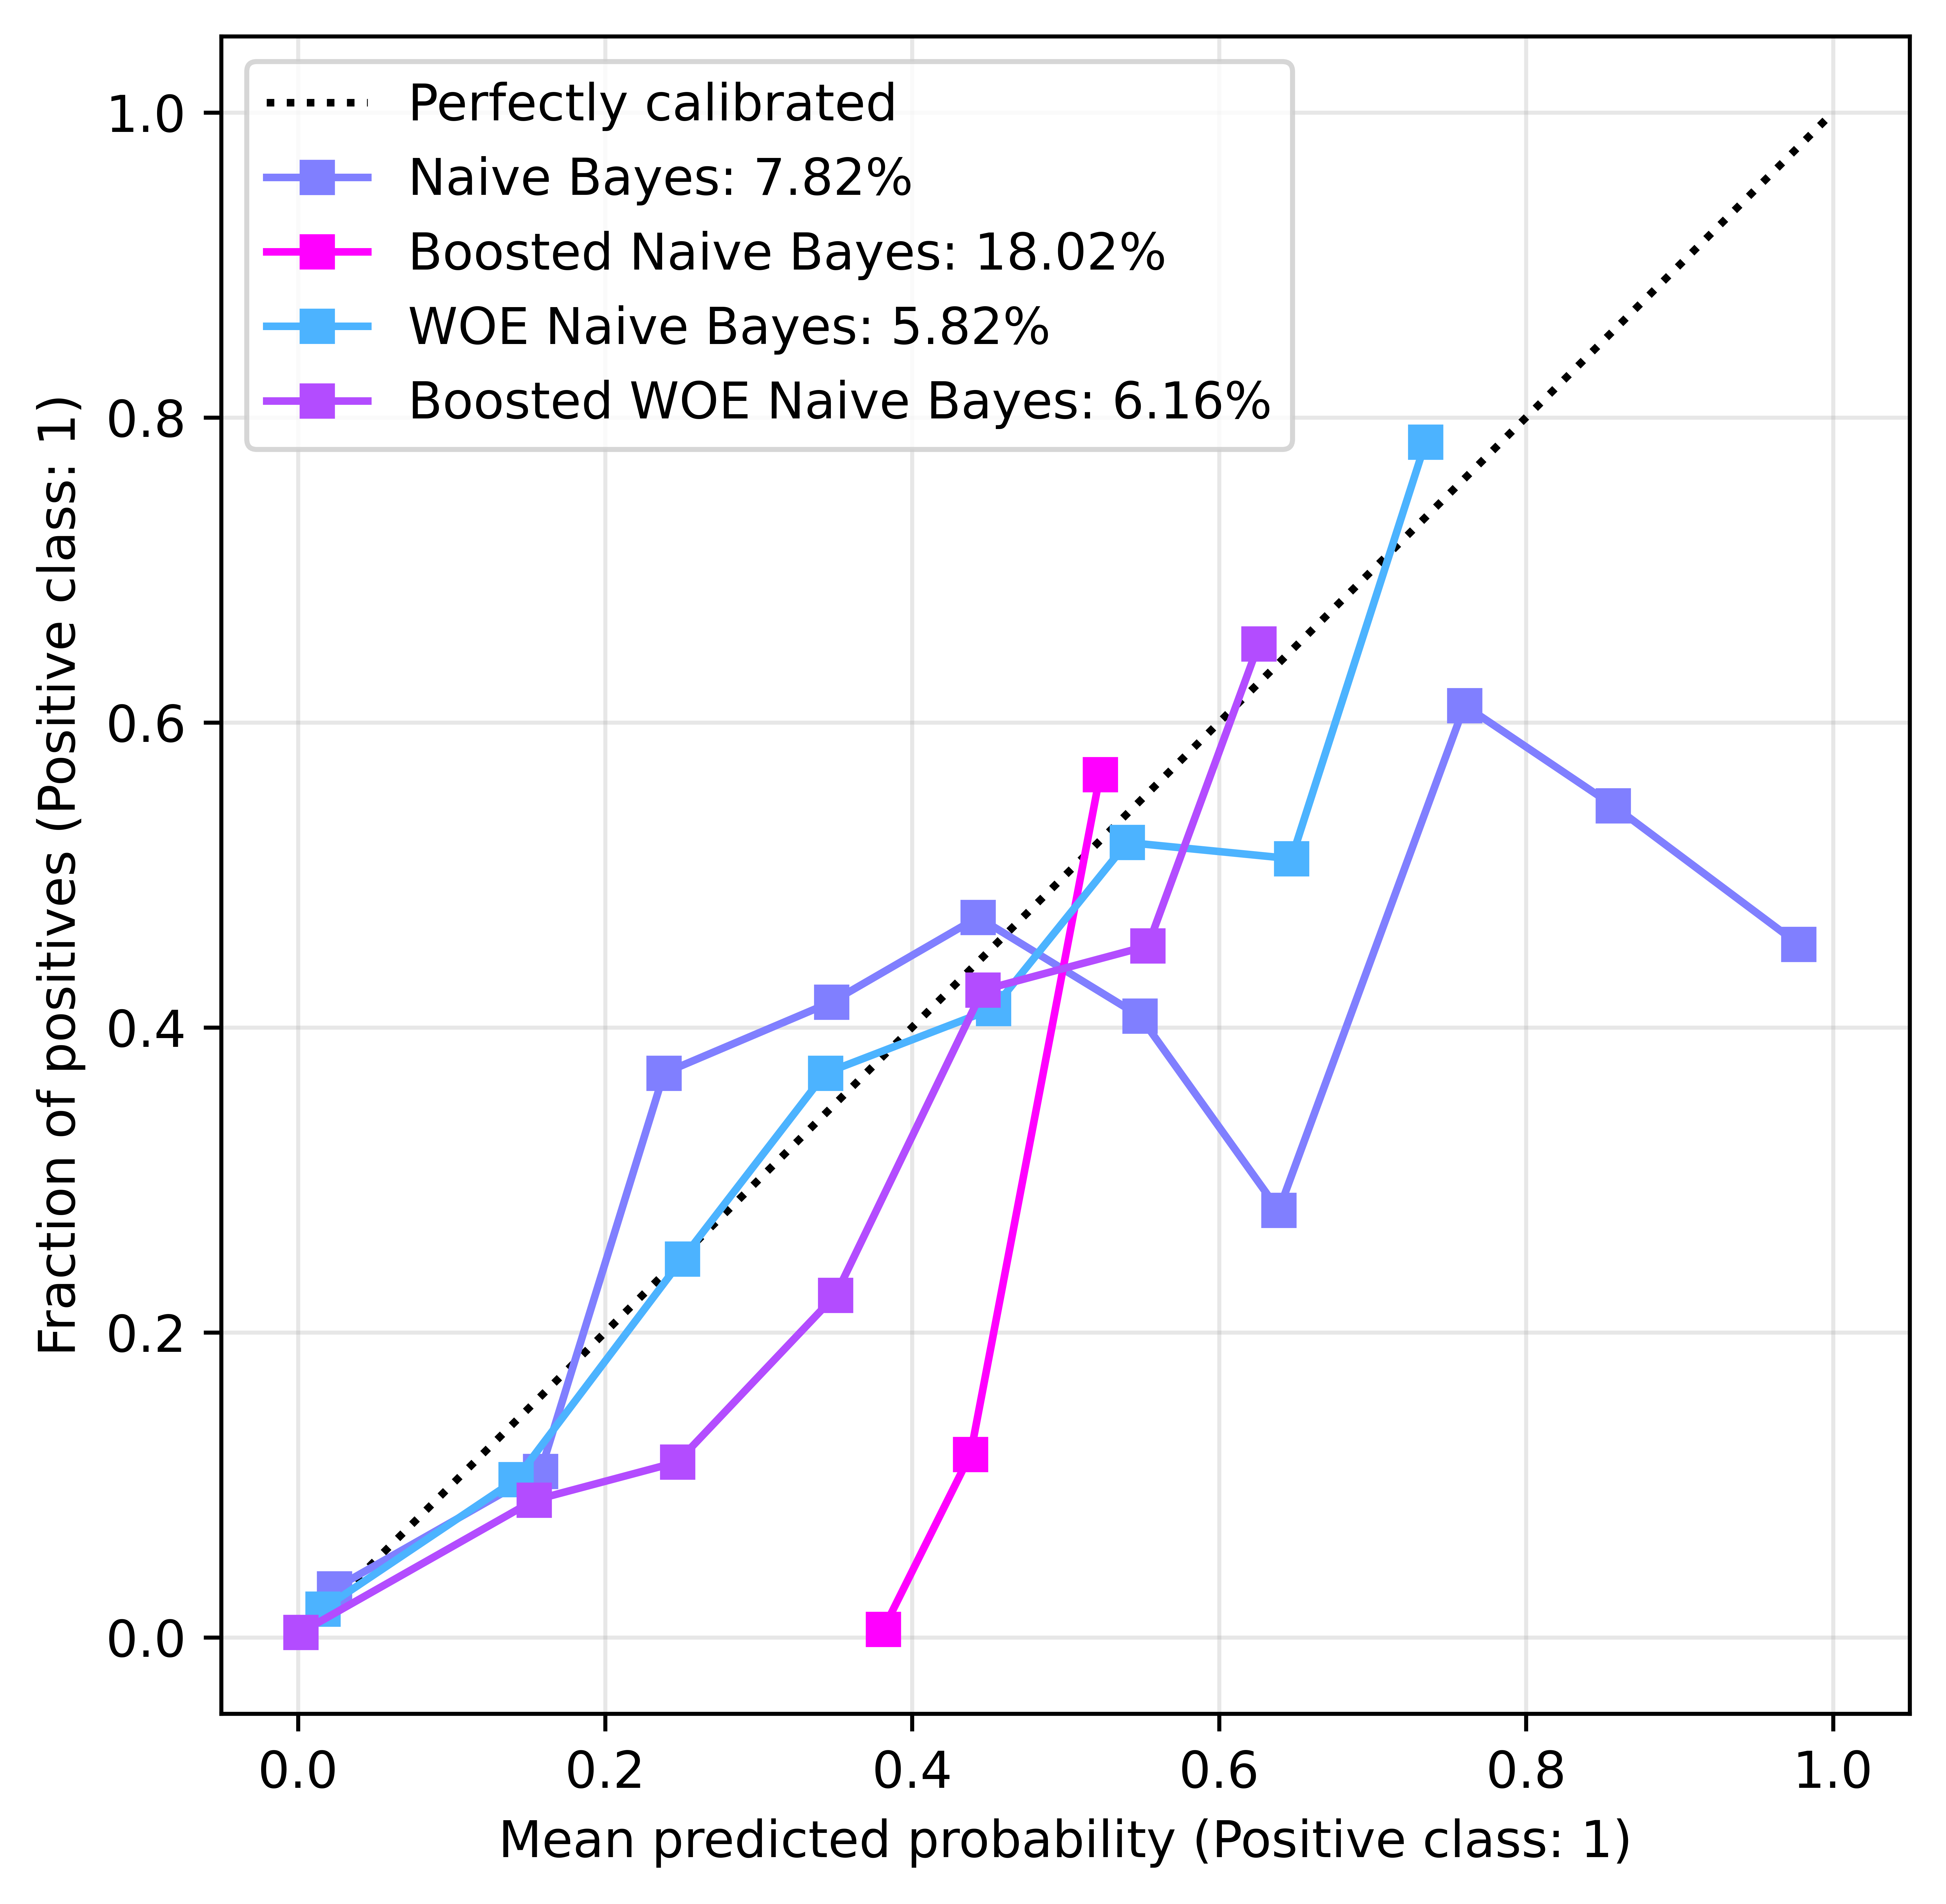

In [1166]:
from sklearn.calibration import CalibrationDisplay
from matplotlib import pyplot as plt
from sklearn.metrics import brier_score_loss

nb_clf.fit(X.loc[ix_train][paired_features], y.loc[ix_train])
adaboost_clf.fit(X.loc[ix_train][paired_features], y.loc[ix_train])
nb_pipe_woe_clf.fit(X.loc[ix_train][paired_features], y.loc[ix_train])
nb_pipe_woe_adaboost.fit(X.loc[ix_train][paired_features], y.loc[ix_train])

predictions_nb = nb_clf.predict_proba(X.loc[ix_test][paired_features])[:, 1]
predictions_nb_adaboost = adaboost_clf.predict_proba(X.loc[ix_test][paired_features])[:, 1]
predictions_woe = nb_pipe_woe_clf.predict_proba(X.loc[ix_test][paired_features])[:, 1]
predictions_woe_adaboost = nb_pipe_woe_adaboost.predict_proba(X.loc[ix_test][paired_features])[:, 1]

model_predictions = [
    ("Naive Bayes", predictions_nb),
    ("Boosted Naive Bayes", predictions_nb_adaboost),
    ("WOE Naive Bayes", predictions_woe),
    ("Boosted WOE Naive Bayes", predictions_woe_adaboost),
]

fig, ax = plt.subplots(figsize=(6, 6), dpi=600)
colors = (
    plt.get_cmap('cool')(0.5), 
    plt.get_cmap('cool')(1.0), 
    plt.get_cmap('cool')(0.3),
    plt.get_cmap('cool')(0.7)
)
for i, (model_name, predictions) in enumerate(model_predictions):
    brier_score = brier_score_loss(y.loc[ix_test], predictions)
    CalibrationDisplay.from_predictions(
        y.loc[ix_test].values.reshape(-1, 1),
        predictions,
        ax=ax,
        name=f"{model_name}: {brier_score:.2%}",
        color=colors[i],
        n_bins=10
)

plt.grid(alpha=0.3)
plt.legend()
plt.show()

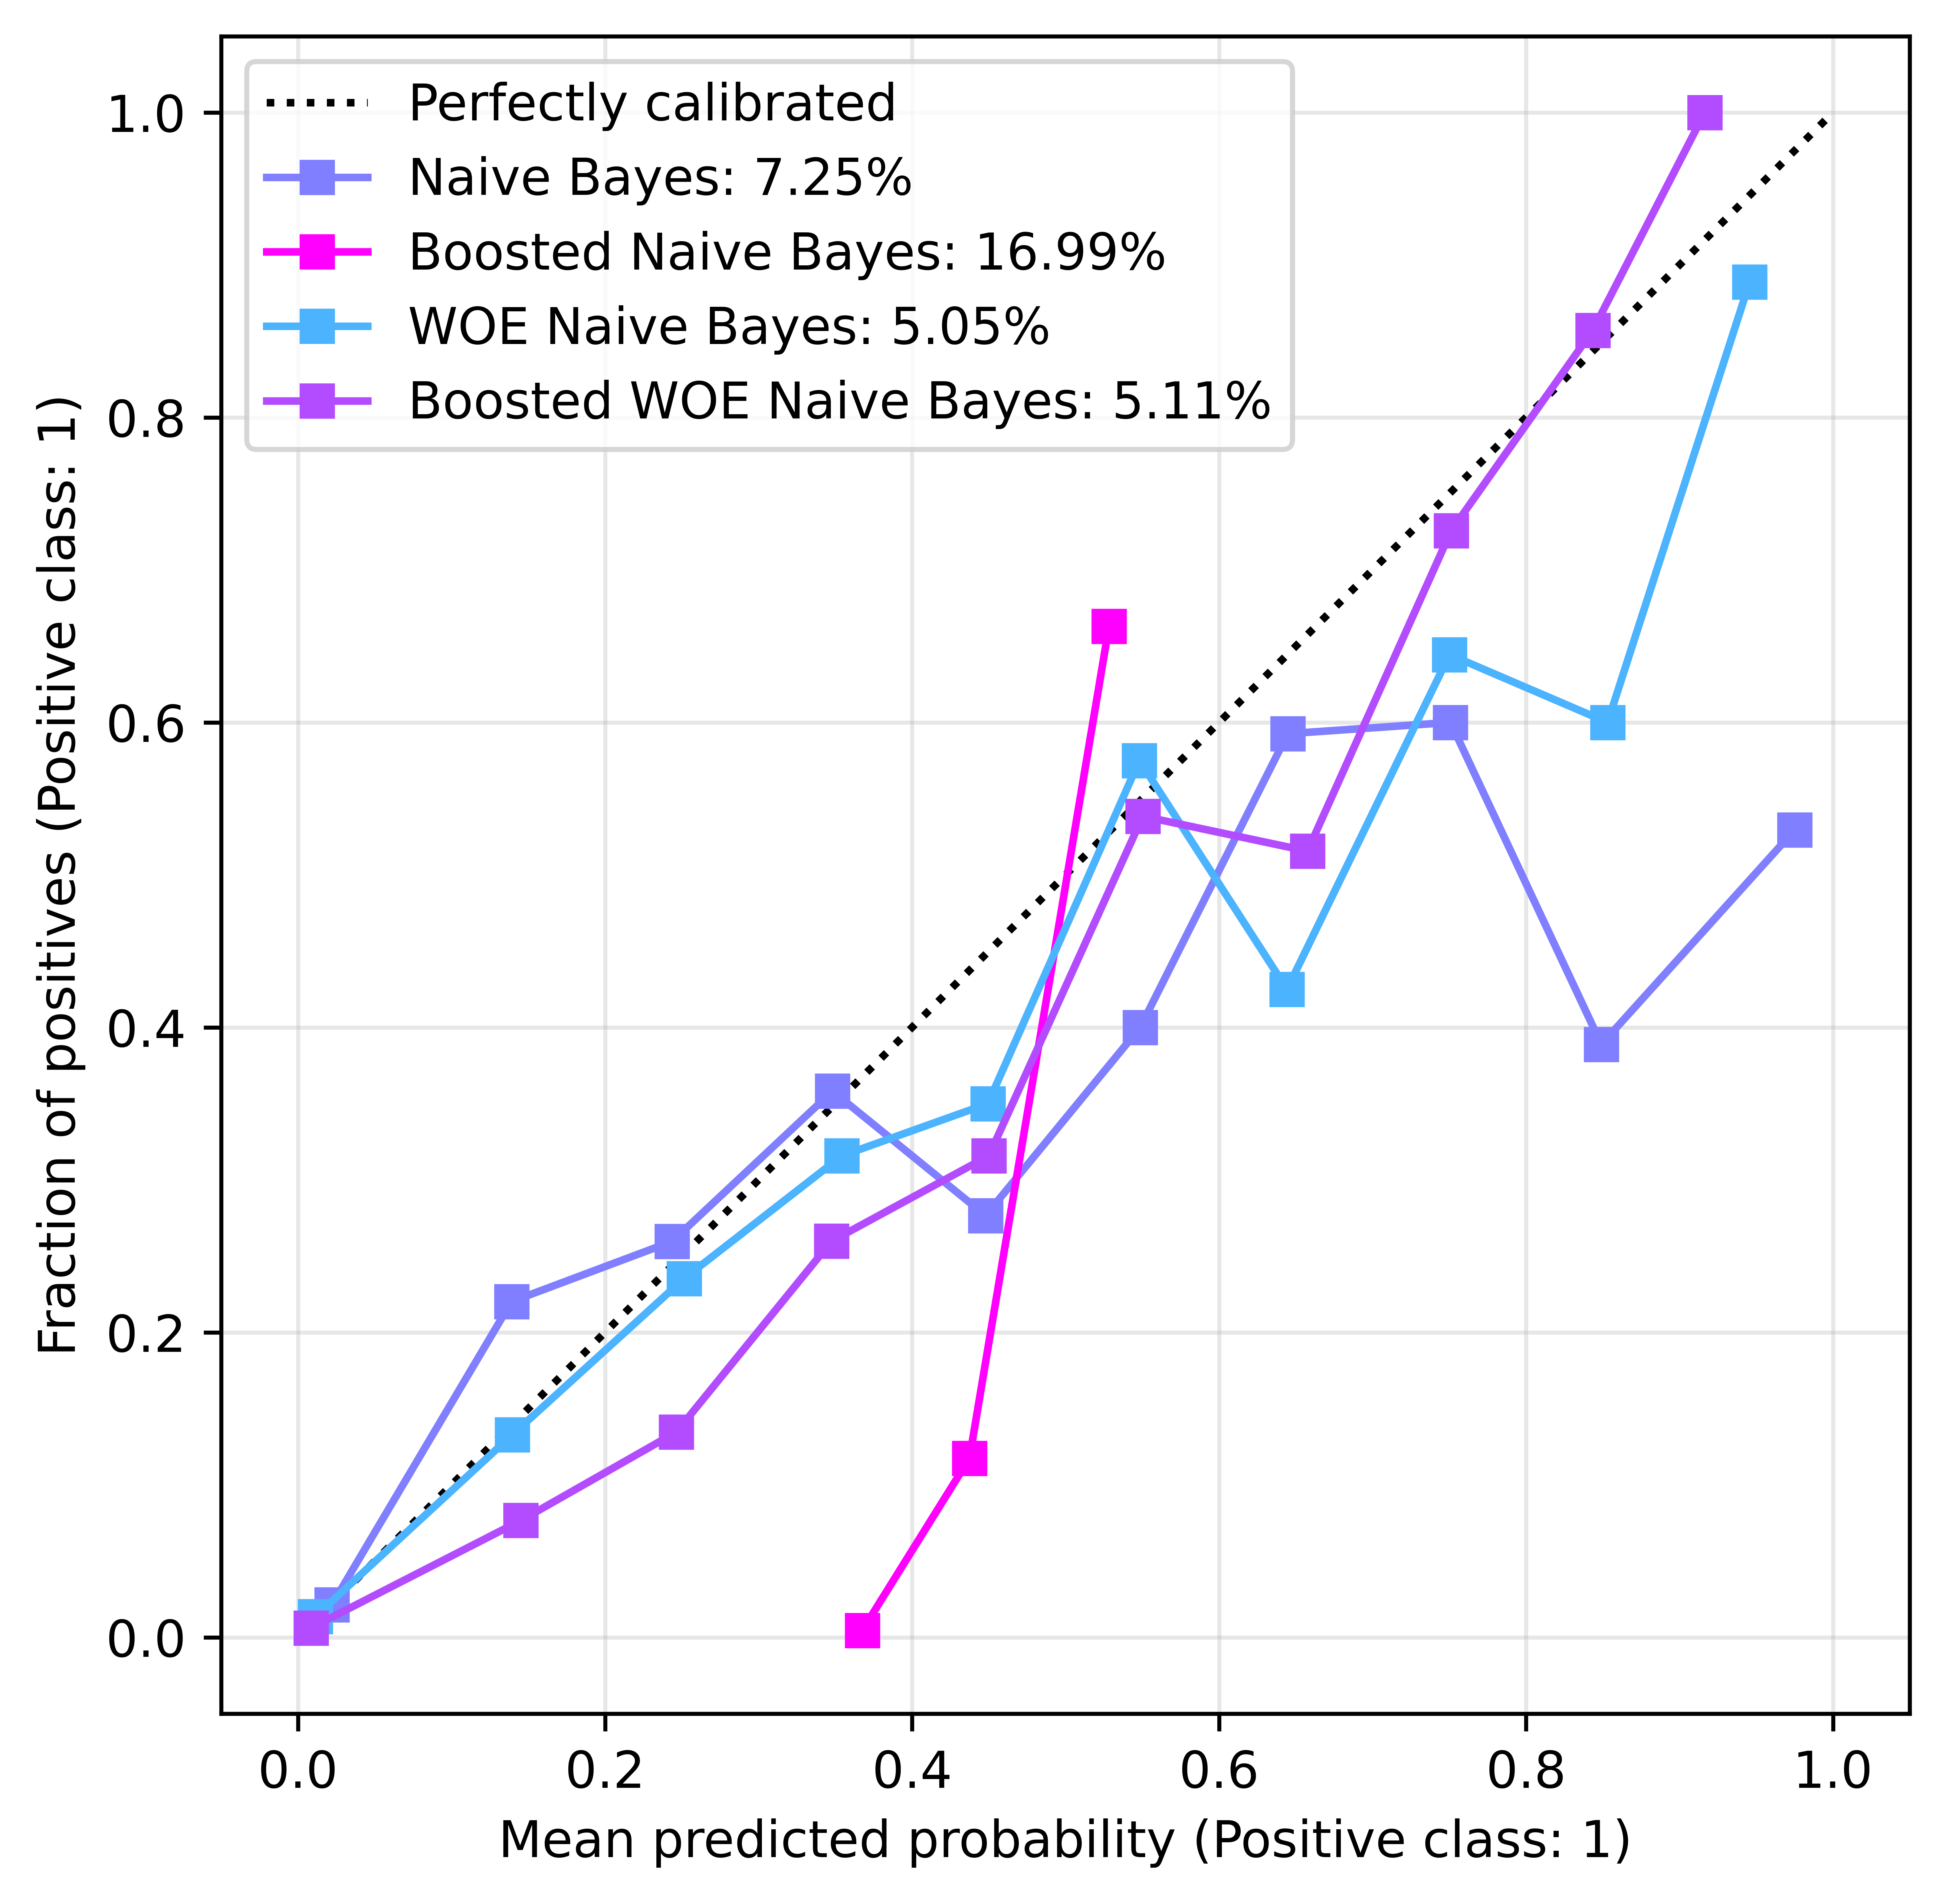

In [1167]:
from sklearn.calibration import CalibrationDisplay
from matplotlib import pyplot as plt
from sklearn.metrics import brier_score_loss

nb_clf.fit(X.loc[ix_train], y.loc[ix_train])
adaboost_clf.fit(X.loc[ix_train], y.loc[ix_train])
nb_pipe_woe_clf.fit(X.loc[ix_train], y.loc[ix_train])
nb_pipe_woe_adaboost.fit(X.loc[ix_train], y.loc[ix_train])

predictions_nb = nb_clf.predict_proba(X.loc[ix_test])[:, 1]
predictions_nb_adaboost = adaboost_clf.predict_proba(X.loc[ix_test])[:, 1]
predictions_woe = nb_pipe_woe_clf.predict_proba(X.loc[ix_test])[:, 1]
predictions_woe_adaboost = nb_pipe_woe_adaboost.predict_proba(X.loc[ix_test])[:, 1]

model_predictions = [
    ("Naive Bayes", predictions_nb),
    ("Boosted Naive Bayes", predictions_nb_adaboost),
    ("WOE Naive Bayes", predictions_woe),
    ("Boosted WOE Naive Bayes", predictions_woe_adaboost),
]

fig, ax = plt.subplots(figsize=(6, 6), dpi=600)
colors = (
    plt.get_cmap('cool')(0.5), 
    plt.get_cmap('cool')(1.0), 
    plt.get_cmap('cool')(0.3),
    plt.get_cmap('cool')(0.7)
)
for i, (model_name, predictions) in enumerate(model_predictions):
    brier_score = brier_score_loss(y.loc[ix_test], predictions)
    CalibrationDisplay.from_predictions(
        y.loc[ix_test].values.reshape(-1, 1),
        predictions,
        ax=ax,
        name=f"{model_name}: {brier_score:.2%}",
        color=colors[i],
        n_bins=10
)

plt.grid(alpha=0.3)
plt.legend()
plt.show()